<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_VGG19_Trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 11 04:07:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.785597890999952
GPU (s):
0.03693404000000555
GPU speedup over CPU: 75x


In [ ]:
from google.colab import drive
import os
import glob
import pandas as pd

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/galaxy-images/img_RGB.zip /content/img_RGB.zip

In [ ]:
!unzip /content/img_RGB.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/img_RGB/spiral/598869.jpg  
  inflating: content/img_RGB/spiral/111799.jpg  
  inflating: content/img_RGB/spiral/780317.jpg  
  inflating: content/img_RGB/spiral/910544.jpg  
  inflating: content/img_RGB/spiral/834411.jpg  
  inflating: content/img_RGB/spiral/733208.jpg  
  inflating: content/img_RGB/spiral/886610.jpg  
  inflating: content/img_RGB/spiral/911110.jpg  
  inflating: content/img_RGB/spiral/708993.jpg  
  inflating: content/img_RGB/spiral/412282.jpg  
  inflating: content/img_RGB/spiral/329964.jpg  
  inflating: content/img_RGB/spiral/550580.jpg  
  inflating: content/img_RGB/spiral/481037.jpg  
  inflating: content/img_RGB/spiral/981685.jpg  
  inflating: content/img_RGB/spiral/213331.jpg  
  inflating: content/img_RGB/spiral/545684.jpg  
  inflating: content/img_RGB/spiral/979242.jpg  
  inflating: content/img_RGB/spiral/791017.jpg  
  inflating: content/img_RGB/spiral/797954.jpg  
  inflating: conte

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
!pip install tensorflow-io
import tensorflow_io as tfio

     |████████████████████████████████| 23.4 MB 128 kB/s 


In [ ]:
def train_model(convert_color, original=False, preprocess=False):

  data_dir = pathlib.Path('/content/content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = True

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if original == True:
    print("Using the original RGB and preprocessing")
    x = tf.keras.applications.vgg19.preprocess_input(x)
  elif original == False:
    x = tf.keras.layers.Rescaling(scale=1./255)(x)
    x = convert_color(x)
    print("Using the converted colors")

  if preprocess == True:
    x = tf.keras.applications.vgg19.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=50
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
80150528/80134624 [==============================] - 1s 0us/step
Using the original RGB and preprocessing
Epoch 1/50
360/360 [==============================] - 117s 217ms/step - loss: 1.6409 - accuracy: 0.2808 - val_loss: 1.4160 - val_accuracy: 0.2890
Epoch 2/50
360/360 [==============================] - 64s 179ms/step - loss: 1.1480 - accuracy: 0.4611 - val_loss: 0.6826 - val_accuracy: 0.7051
Epoch 3/50
360/360 [==============================] - 64s 179ms/step - loss: 0.4820 - accuracy: 0.8148 - val_loss: 0.4355 - val_accuracy: 0.8388
Epoch 4/50
360/360 [==============================] - 65s 181ms/step - loss: 0.3713 - accuracy: 0.8619 - val_loss: 0.2706 - val_accuracy: 0.9010
Epoch 5/50
360/360 [==============================] - 65s 179ms/step - loss: 0.3195 - accuracy: 0.8841 - val_loss: 0.3092 - val_accuracy: 0.8892
Epoch 6/50
360/360 

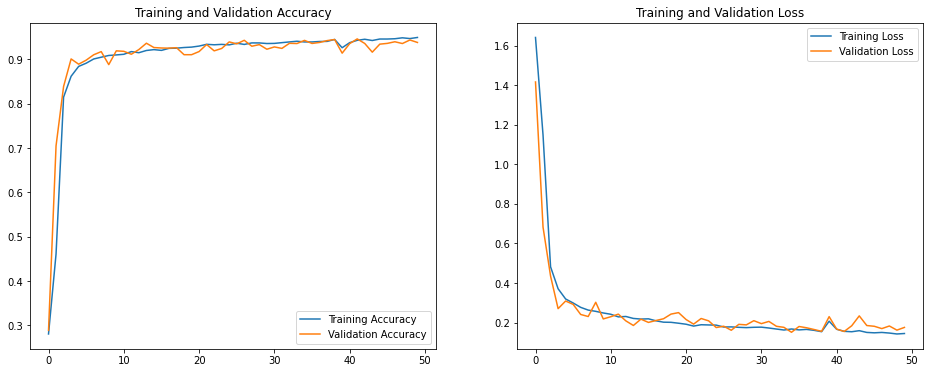

In [ ]:
train_model(None, original=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 89s 194ms/step - loss: 1.5329 - accuracy: 0.2827 - val_loss: 1.4245 - val_accuracy: 0.2890
Epoch 2/50
360/360 [==============================] - 64s 178ms/step - loss: 1.2606 - accuracy: 0.4029 - val_loss: 0.8789 - val_accuracy: 0.5896
Epoch 3/50
360/360 [==============================] - 64s 178ms/step - loss: 0.7674 - accuracy: 0.6721 - val_loss: 0.6251 - val_accuracy: 0.7404
Epoch 4/50
360/360 [==============================] - 65s 180ms/step - loss: 0.5359 - accuracy: 0.7958 - val_loss: 0.5156 - val_accuracy: 0.8159
Epoch 5/50
360/360 [==============================] - 65s 181ms/step - loss: 0.4334 - accuracy: 0.8404 - val_loss: 0.3921 - val_accuracy: 0.8585
Epoch 6/50
360/360 [==============================] - 65s 182ms/step - loss: 0.

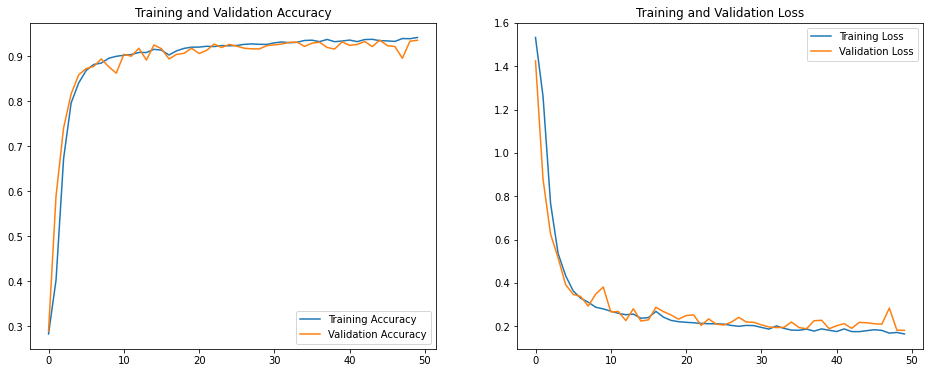

In [ ]:
train_model(tfio.experimental.color.rgb_to_lab, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 82s 187ms/step - loss: 1.1977 - accuracy: 0.4732 - val_loss: 0.8906 - val_accuracy: 0.5976
Epoch 2/50
360/360 [==============================] - 67s 186ms/step - loss: 0.7858 - accuracy: 0.6550 - val_loss: 0.5870 - val_accuracy: 0.7581
Epoch 3/50
360/360 [==============================] - 67s 186ms/step - loss: 0.5312 - accuracy: 0.7971 - val_loss: 0.4434 - val_accuracy: 0.8553
Epoch 4/50
360/360 [==============================] - 67s 186ms/step - loss: 0.3712 - accuracy: 0.8689 - val_loss: 0.3730 - val_accuracy: 0.8651
Epoch 5/50
360/360 [==============================] - 66s 183ms/step - loss: 0.3196 - accuracy: 0.8866 - val_loss: 0.2843 - val_accuracy: 0.9057
Epoch 6/50
360/360 [==============================] - 66s 185ms/step - loss: 0.2924 - accuracy: 0.8

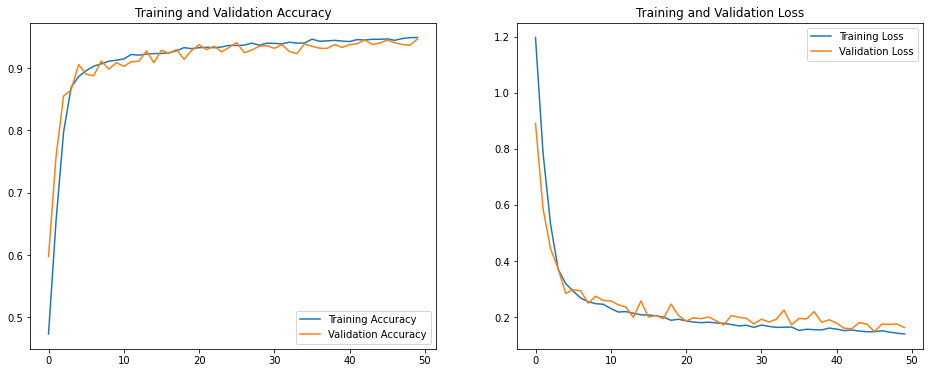

In [ ]:
train_model(tfio.experimental.color.rgb_to_lab, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 78s 178ms/step - loss: 1.5107 - accuracy: 0.2844 - val_loss: 1.4198 - val_accuracy: 0.2860
Epoch 2/50
360/360 [==============================] - 64s 176ms/step - loss: 1.4325 - accuracy: 0.2843 - val_loss: 1.4141 - val_accuracy: 0.2890
Epoch 3/50
360/360 [==============================] - 64s 178ms/step - loss: 1.4279 - accuracy: 0.2878 - val_loss: 1.4192 - val_accuracy: 0.2746
Epoch 4/50
360/360 [==============================] - 63s 174ms/step - loss: 1.4258 - accuracy: 0.2898 - val_loss: 1.4259 - val_accuracy: 0.2890
Epoch 5/50
360/360 [==============================] - 62s 173ms/step - loss: 1.4254 - accuracy: 0.2855 - val_loss: 1.4213 - val_accuracy: 0.2890
Epoch 6/50
360/360 [==============================] - 62s 173ms/step - loss: 1.

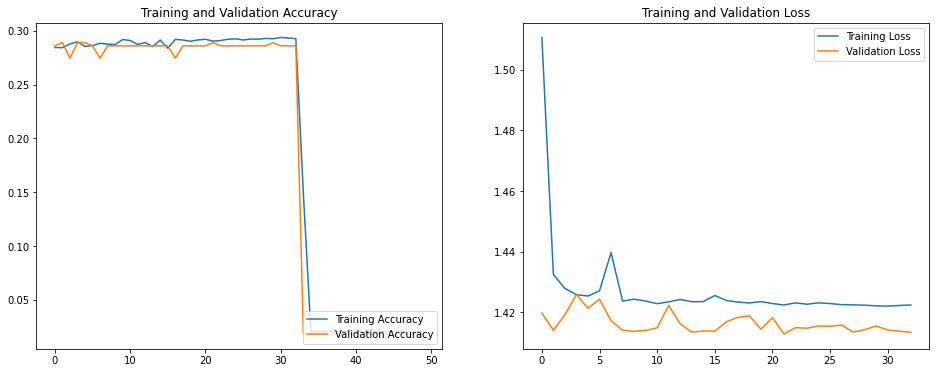

In [ ]:
train_model(tfio.experimental.color.rgb_to_xyz, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 81s 186ms/step - loss: 1.4423 - accuracy: 0.2827 - val_loss: 1.4160 - val_accuracy: 0.2860
Epoch 2/50
360/360 [==============================] - 66s 185ms/step - loss: 1.4265 - accuracy: 0.2909 - val_loss: 1.4170 - val_accuracy: 0.2746
Epoch 3/50
360/360 [==============================] - 66s 183ms/step - loss: 1.4257 - accuracy: 0.2892 - val_loss: 1.4279 - val_accuracy: 0.2890
Epoch 4/50
360/360 [==============================] - 66s 184ms/step - loss: 1.4254 - accuracy: 0.2873 - val_loss: 1.4143 - val_accuracy: 0.2860
Epoch 5/50
360/360 [==============================] - 67s 185ms/step - loss: 1.4242 - accuracy: 0.2899 - val_loss: 1.4126 - val_accuracy: 0.2890
Epoch 6/50
360/360 [==============================] - 65s 181ms/step - loss: 1.4308 - accuracy: 0.2

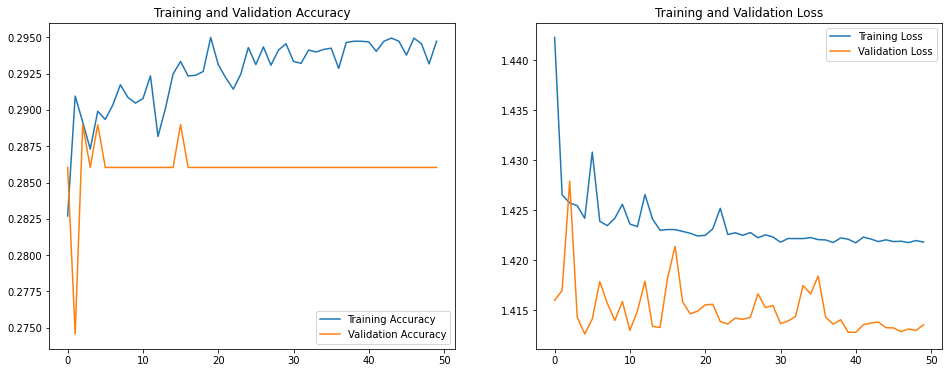

In [ ]:
train_model(tfio.experimental.color.rgb_to_xyz, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
80150528/80134624 [==============================] - 1s 0us/step
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 98s 191ms/step - loss: 1.4781 - accuracy: 0.2823 - val_loss: 1.4130 - val_accuracy: 0.2890
Epoch 2/50
360/360 [==============================] - 66s 183ms/step - loss: 1.4309 - accuracy: 0.2847 - val_loss: 1.4144 - val_accuracy: 0.2860
Epoch 3/50
360/360 [==============================] - 66s 183ms/step - loss: 1.4254 - accuracy: 0.2868 - val_loss: 1.4129 - val_accuracy: 0.2746
Epoch 4/50
360/360 [==============================] - 66s 183ms/step - loss: 1.4245 - accuracy: 0.2879 - val_loss: 1.4235 - val_accuracy: 0.2860
Epoch 5/50
360/360 [==============================] - 66s 183ms/step - loss: 1.4247 - accuracy: 0.2887 - val_loss: 1.4142 - val_accuracy: 0.2890
Epoch 6/50
360

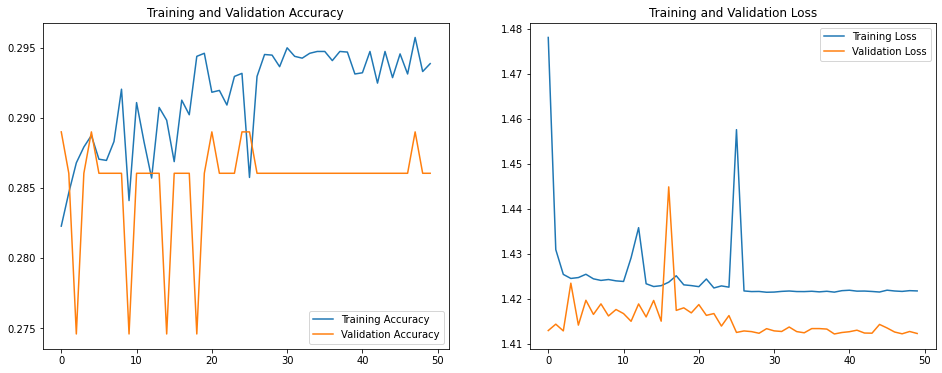

In [ ]:
train_model(tfio.experimental.color.rgb_to_hsv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 80s 185ms/step - loss: 1.1422 - accuracy: 0.4875 - val_loss: 0.8182 - val_accuracy: 0.6287
Epoch 2/50
360/360 [==============================] - 66s 183ms/step - loss: 0.6976 - accuracy: 0.7119 - val_loss: 0.4700 - val_accuracy: 0.8289
Epoch 3/50
360/360 [==============================] - 66s 183ms/step - loss: 0.4151 - accuracy: 0.8488 - val_loss: 0.3306 - val_accuracy: 0.8758
Epoch 4/50
360/360 [==============================] - 66s 183ms/step - loss: 0.3454 - accuracy: 0.8772 - val_loss: 0.3312 - val_accuracy: 0.8770
Epoch 5/50
360/360 [==============================] - 66s 183ms/step - loss: 0.3069 - accuracy: 0.8894 - val_loss: 0.2790 - val_accuracy: 0.9003
Epoch 6/50
360/360 [==============================] - 66s 183ms/step - loss: 0.2784 - accuracy: 0.9

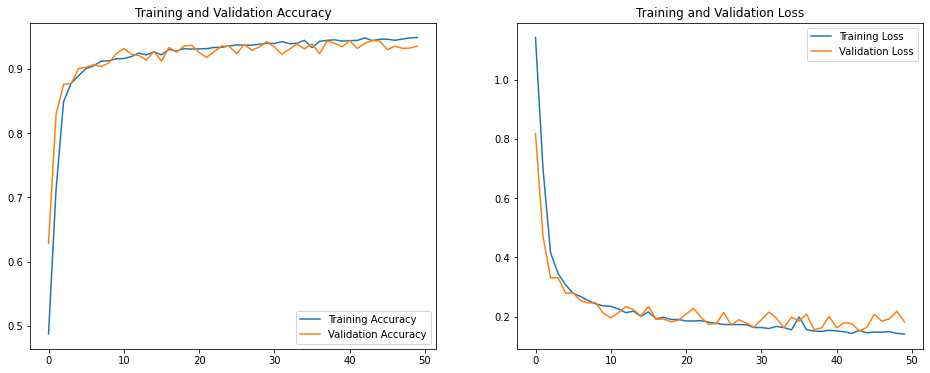

In [ ]:
train_model(tfio.experimental.color.rgb_to_hsv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 81s 186ms/step - loss: 1.4779 - accuracy: 0.2792 - val_loss: 1.4192 - val_accuracy: 0.2860
Epoch 2/50
360/360 [==============================] - 66s 184ms/step - loss: 1.4302 - accuracy: 0.2799 - val_loss: 1.4178 - val_accuracy: 0.2860
Epoch 3/50
360/360 [==============================] - 66s 184ms/step - loss: 1.4264 - accuracy: 0.2877 - val_loss: 1.4230 - val_accuracy: 0.2746
Epoch 4/50
360/360 [==============================] - 66s 184ms/step - loss: 1.4252 - accuracy: 0.2840 - val_loss: 1.4211 - val_accuracy: 0.2860
Epoch 5/50
360/360 [==============================] - 66s 184ms/step - loss: 1.4243 - accuracy: 0.2891 - val_loss: 1.4149 - val_accuracy: 0.2860
Epoch 6/50
360/360 [==============================] - 66s 184ms/step - loss: 1.

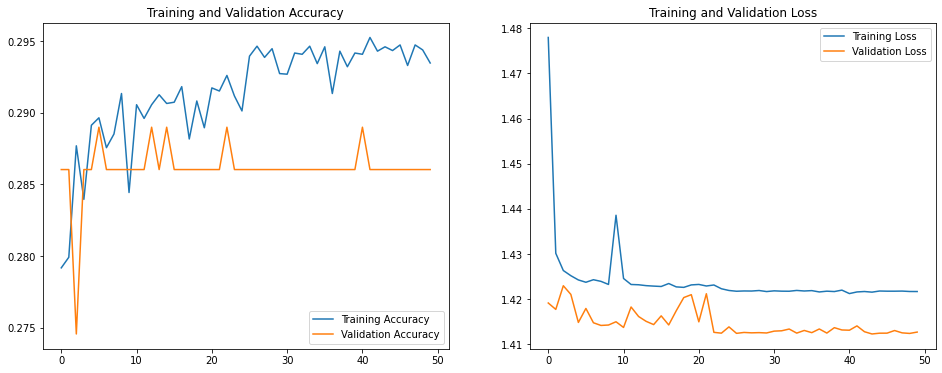

In [ ]:
train_model(tfio.experimental.color.rgb_to_yuv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 81s 186ms/step - loss: 1.4420 - accuracy: 0.2822 - val_loss: 1.4178 - val_accuracy: 0.2746
Epoch 2/50
360/360 [==============================] - 66s 183ms/step - loss: 1.4284 - accuracy: 0.2871 - val_loss: 1.4191 - val_accuracy: 0.2890
Epoch 3/50
360/360 [==============================] - 66s 184ms/step - loss: 1.4253 - accuracy: 0.2884 - val_loss: 1.4214 - val_accuracy: 0.2860
Epoch 4/50
360/360 [==============================] - 66s 183ms/step - loss: 1.4313 - accuracy: 0.2863 - val_loss: 1.4180 - val_accuracy: 0.2890
Epoch 5/50
360/360 [==============================] - 66s 183ms/step - loss: 0.9195 - accuracy: 0.5858 - val_loss: 0.4745 - val_accuracy: 0.8246
Epoch 6/50
360/360 [==============================] - 66s 183ms/step - loss: 0.4188 - accuracy: 0.8

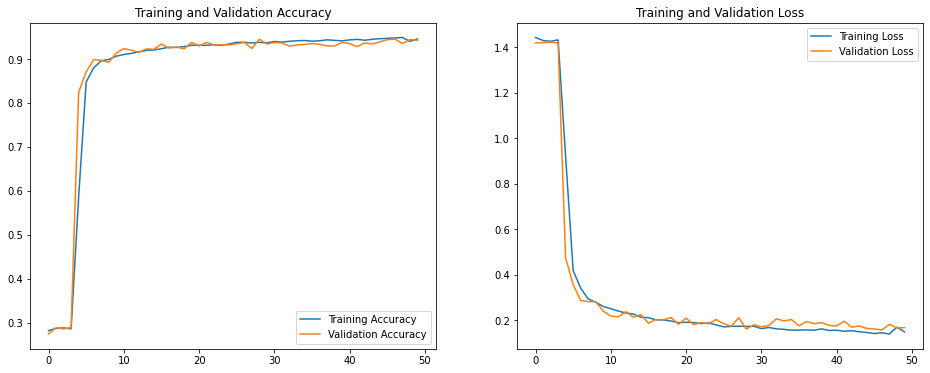

In [ ]:
train_model(tfio.experimental.color.rgb_to_yuv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 80s 186ms/step - loss: 1.5760 - accuracy: 0.2833 - val_loss: 1.4187 - val_accuracy: 0.2860
Epoch 2/50
360/360 [==============================] - 66s 183ms/step - loss: 1.4318 - accuracy: 0.2864 - val_loss: 1.4177 - val_accuracy: 0.2860
Epoch 3/50
360/360 [==============================] - 66s 184ms/step - loss: 1.4288 - accuracy: 0.2829 - val_loss: 1.4229 - val_accuracy: 0.2860
Epoch 4/50
360/360 [==============================] - 66s 184ms/step - loss: 1.4265 - accuracy: 0.2837 - val_loss: 1.4138 - val_accuracy: 0.2890
Epoch 5/50
360/360 [==============================] - 66s 184ms/step - loss: 1.4260 - accuracy: 0.2876 - val_loss: 1.4194 - val_accuracy: 0.2860
Epoch 6/50
360/360 [==============================] - 66s 184ms/step - loss: 1.

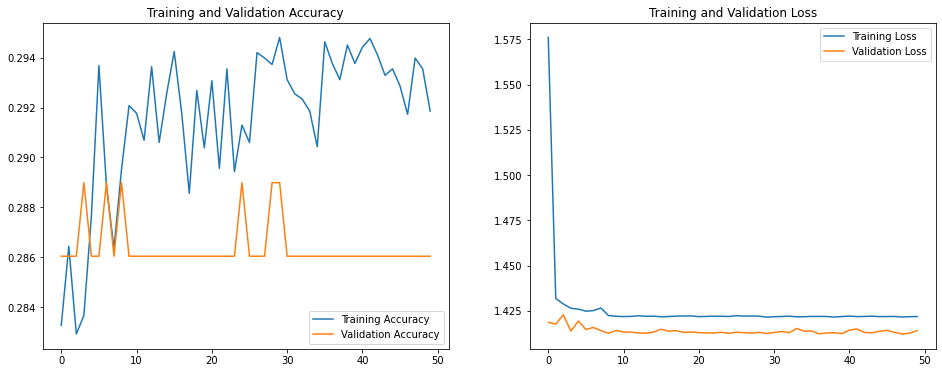

In [ ]:
train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 83s 194ms/step - loss: 1.3490 - accuracy: 0.3689 - val_loss: 1.1057 - val_accuracy: 0.5274
Epoch 2/50
360/360 [==============================] - 66s 184ms/step - loss: 0.7837 - accuracy: 0.6777 - val_loss: 0.4797 - val_accuracy: 0.8216
Epoch 3/50
360/360 [==============================] - 66s 184ms/step - loss: 0.4292 - accuracy: 0.8480 - val_loss: 0.3891 - val_accuracy: 0.8644
Epoch 4/50
360/360 [==============================] - 66s 184ms/step - loss: 0.3528 - accuracy: 0.8764 - val_loss: 0.3883 - val_accuracy: 0.8652
Epoch 5/50
360/360 [==============================] - 66s 183ms/step - loss: 0.3068 - accuracy: 0.8912 - val_loss: 0.2830 - val_accuracy: 0.9001
Epoch 6/50
360/360 [==============================] - 66s 184ms/step - loss: 0.2806 - accuracy: 0.9

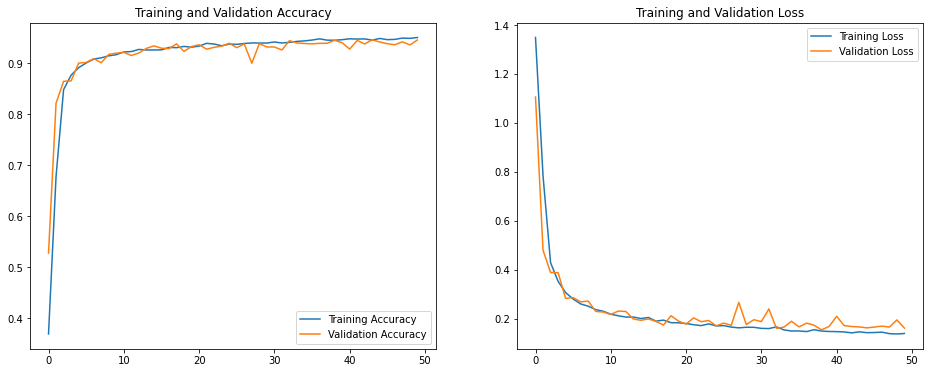

In [15]:
train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=False)